In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score


Veriyi yüklüyor ve ilk 5 satırını inceliyoruz.

In [6]:
df = pd.read_csv("C:/Users/aksan/Downloads/alzheimers_disease_data.csv")
df.head()


,PatientID,Age,Gender,Ethnicity,EducationLevel,BMI,Smoking,AlcoholConsumption,PhysicalActivity,DietQuality,...,MemoryComplaints,BehavioralProblems,ADL,Confusion,Disorientation,PersonalityChanges,DifficultyCompletingTasks,Forgetfulness,Diagnosis,DoctorInCharge
0,4751,73,0,0,2,22.927749,0,13.297218,6.327112,1.347214,...,0,0,1.725883,0,0,0,1,0,0,XXXConfid
1,4752,89,0,0,0,26.827681,0,4.542524,7.619885,0.518767,...,0,0,2.592424,0,0,0,0,1,0,XXXConfid
2,4753,73,0,3,1,17.795882,0,19.555085,7.844988,1.826335,...,0,0,7.119548,0,1,0,1,0,0,XXXConfid
3,4754,74,1,0,1,33.800817,1,12.209266,8.428001,7.435604,...,0,1,6.481226,0,0,0,0,0,0,XXXConfid
4,4755,89,0,0,0,20.716974,0,18.454356,6.310461,0.795498,...,0,0,0.014691,0,0,1,1,0,0,XXXConfid


Veri setindeki eksik değerler ve değişkenlerin tipleri kontrol edilir.

In [7]:
df.info()
df.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2149 entries, 0 to 2148
Data columns (total 35 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   PatientID                  2149 non-null   int64  
 1   Age                        2149 non-null   int64  
 2   Gender                     2149 non-null   int64  
 3   Ethnicity                  2149 non-null   int64  
 4   EducationLevel             2149 non-null   int64  
 5   BMI                        2149 non-null   float64
 6   Smoking                    2149 non-null   int64  
 7   AlcoholConsumption         2149 non-null   float64
 8   PhysicalActivity           2149 non-null   float64
 9   DietQuality                2149 non-null   float64
 10  SleepQuality               2149 non-null   float64
 11  FamilyHistoryAlzheimers    2149 non-null   int64  
 12  CardiovascularDisease      2149 non-null   int64  
 13  Diabetes                   2149 non-null   int64

PatientID                    0
Age                          0
Gender                       0
Ethnicity                    0
EducationLevel               0
BMI                          0
Smoking                      0
AlcoholConsumption           0
PhysicalActivity             0
DietQuality                  0
SleepQuality                 0
FamilyHistoryAlzheimers      0
CardiovascularDisease        0
Diabetes                     0
Depression                   0
HeadInjury                   0
Hypertension                 0
SystolicBP                   0
DiastolicBP                  0
CholesterolTotal             0
CholesterolLDL               0
CholesterolHDL               0
CholesterolTriglycerides     0
MMSE                         0
FunctionalAssessment         0
MemoryComplaints             0
BehavioralProblems           0
ADL                          0
Confusion                    0
Disorientation               0
PersonalityChanges           0
DifficultyCompletingTasks    0
Forgetfu

Tahminle doğrudan ilgisi olmayan kimlik bilgileri kaldırıldı.

In [8]:
df.drop(["PatientID", "DoctorInCharge"], axis=1, inplace=True)


Bu adımda eksik veriye sahip tüm satırlar veri setinden çıkarıldı.



In [9]:
df = df.dropna()


Diagnosis hedef değişken olarak belirlendi.

In [10]:
X = df.drop("Diagnosis", axis=1)
y = df["Diagnosis"]


Sayısal veriler standartlaştırılarak model için uygun hale getirildi.

In [11]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


 kategorik değişkenler modelin anlayabilmesi için sayısal forma çevrildi.

In [17]:

df = pd.get_dummies(df, columns=['Gender', 'Ethnicity', 'EducationLevel'], drop_first=True)


Veri seti %80 eğitim, %20 test olacak şekilde ikiye ayrıldı.

In [19]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)


 Random Forest algoritması ile model eğitildi.

In [20]:
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

Modelin sınıflandırma başarımı doğruluk, f1, precision ve recall metrikleri ile ölçüldü.

In [21]:
y_pred = model.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


[[272   5]
 [ 27 126]]
              precision    recall  f1-score   support

           0       0.91      0.98      0.94       277
           1       0.96      0.82      0.89       153

    accuracy                           0.93       430
   macro avg       0.94      0.90      0.92       430
weighted avg       0.93      0.93      0.92       430



Gerçek ve tahmin edilen sınıflar arasındaki karşılaştırma görselleştirildi.

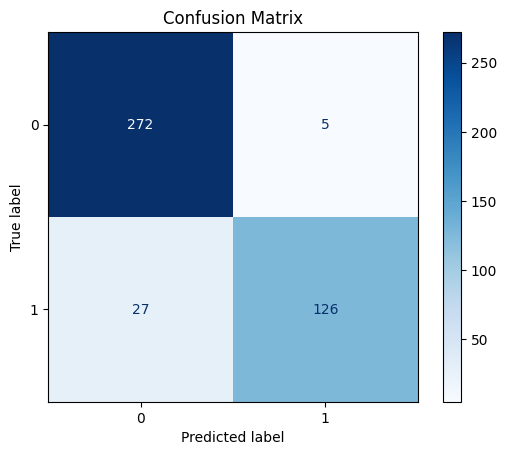

In [22]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()


ROC eğrisi modeli hasta sınıfını ne kadar başarılı ayırabildiğini gösterir. AUC ne kadar 1'e yakınsa o kadar iyidir.



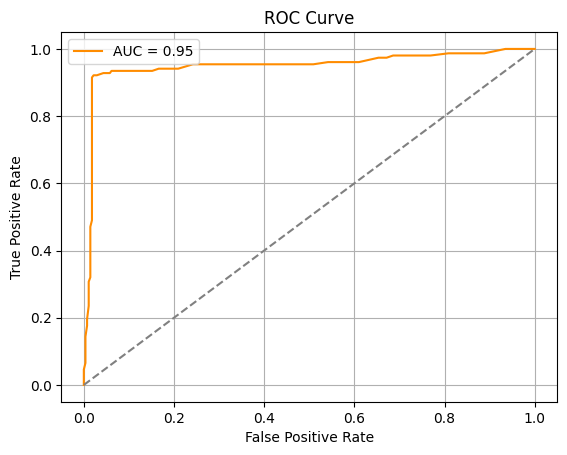

In [16]:
y_prob = model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)

plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}", color="darkorange")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()
